In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import bitstring
import sklearn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# read csv

# Read CSV files
high_launch_data = pd.read_csv('data/carmf5_HIGHDATA.CSV')
low_launch_data = pd.read_csv('data/carmf5_LOWDATA.CSV')

/tmp/ipykernel_116942/2959646373.py:13: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  high_launch_data = pd.read_csv('data/carmf5_HIGHDATA.CSV')
/tmp/ipykernel_116942/2959646373.py:14: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  low_launch_data = pd.read_csv('data/carmf5_LOWDATA.CSV')


/tmp/ipykernel_116942/1423153387.py:34: RuntimeWarning: divide by zero encountered in log2
  bit_set = np.ceil(np.log2(diff)) - np.ceil(np.log2(diff - (diff & diff - 1)))
/tmp/ipykernel_116942/1423153387.py:34: RuntimeWarning: invalid value encountered in double_scalars
  bit_set = np.ceil(np.log2(diff)) - np.ceil(np.log2(diff - (diff & diff - 1)))


0b10111101000100110000101111100001 0b10111101000100110000101111100001 0 nan
0b10111101000100110000101111100001 0b111110000001000100110100000001 2199340768 27.0
0b111110000001000100110100000001 0b10111101101000011100101011000001 2208663488 26.0
0b10111101101000011100101011000001 0b10111100111010110001110001000011 21681794 24.0
0b10111100111010110001110001000011 0b111101001100001000100110100000 2178651619 32.0
0b111101001100001000100110100000 0b10111101110011011101001011110010 2164087634 31.0
0b10111101110011011101001011110010 0b10111101000100110000101111100001 14604563 24.0
0b10111101000100110000101111100001 0b10111101110111001001000111010001 13605424 20.0
0b10111101110111001001000111010001 0b10111110100000001001110101001001 56364184 23.0
0b10111110100000001001110101001001 0b10111101100001000100110100000001 50647112 23.0
0b10111101100001000100110100000001 0b10111110001010010000111111111001 61686520 23.0
0b10111110001010010000111111111001 0b10111101010011011001111010000100 56922493 26.0


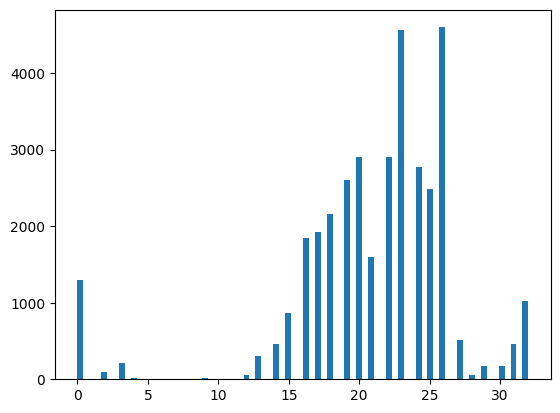

In [21]:
fig = plt.figure()
ax = fig.add_subplot()
all_floats = high_launch_data['time (ms)'] + high_launch_data['av bay temperature (C)'] 
all_floats += high_launch_data['barometer temp (C)'] 
all_floats += high_launch_data['air pressure (kPa)'] 
all_floats += high_launch_data['x acceleration (m/s^2)'] 
all_floats += high_launch_data['y acceleration (m/s^2)'] 
all_floats += high_launch_data['z acceleration (m/s^2)'] 
all_floats += high_launch_data['x magnetic force (gauss)'] 
all_floats += high_launch_data['y magnetic force (gauss)']
all_floats += high_launch_data['z magnetic force (gauss)'] 
all_floats += high_launch_data['x gyro (dps)']
all_floats += high_launch_data['y gyro (dps)']
all_floats += high_launch_data['z gyro (dps)'] 
all_floats += high_launch_data['raw altitude (m)'] 
all_floats += high_launch_data['altitude (m)'] 

def exp_of_float(f):
    f1 = bitstring.BitStream(float=f, length=32)
    f1.pos = 1
    return f1.read('uint8')

def bit_of_float(f):
    f1 = bitstring.BitStream(float=f, length=32)
    return f1.read('uint32')

exp_data = [exp_of_float(f) for f in all_floats]

bits_different = [32]
z_accel_bits = [ bit_of_float(f) for f in high_launch_data['z acceleration (m/s^2)'] ]
current_val = z_accel_bits[0]
for v in z_accel_bits[1:]:
    diff = current_val ^ v
    bit_set = np.ceil(np.log2(diff)) - np.ceil(np.log2(diff - (diff & diff - 1)))
    print(bin(current_val), bin(v), diff, bit_set)
    if (np.isnan(bit_set)):
        bits_different += [0]   
    else:
        bits_different += [bit_set]
    current_val = v


ax.hist(bits_different, bins='auto')
#ax.plot(high_launch_data['time (ms)'], high_launch_data['barometer temp (C)'])
plt.show()

In [2]:
# clear bad data

del high_launch_data['STATE']
del high_launch_data['engine bay temperature (C)']
del high_launch_data['external temperature (C)']
del high_launch_data['kf vertical velocity (m/s)']
del high_launch_data['kf vertical acceleration (m/s^2)']
del high_launch_data['kf altitude (m)']
del high_launch_data['gps lat']
del high_launch_data['gps long']
del high_launch_data['gps speed']
del high_launch_data['gps angle']
del high_launch_data['gps altitude']
del high_launch_data['gps fix']
del high_launch_data['gps fix quality']
del high_launch_data['gps satellites']
del high_launch_data['gps antenna status']
del high_launch_data['error flags']

# do low data later


In [3]:
# calculate k means

def k_means(data, k, max_iterations=100):
    centroids = initialize_centroids(data, k) # some random initialization for centroids (codebook)
    for iteration in range(max_iterations): # some convergence criteria
        # Assign data points to the nearest centroid -- this is the partition step
        clusters = assign_data_to_centroids(data, centroids)
        # Calculate new centroids -- this is the codebook update step
        new_centroids = calculate_new_centroids(data, clusters)
        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids # update centroids
    return clusters, centroids

def initialize_centroids(data, k):
    # Randomly select k data points as initial centroids
    return data[np.random.choice(len(data), k, replace=False)]

def assign_data_to_centroids(data, centroids):
    # Assign each data point to the nearest centroid
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    clusters = np.argmin(distances, axis=1)
    return clusters

def calculate_new_centroids(data, clusters):
    # Calculate new centroids as the mean of data points in each cluster
    new_centroids = np.array([data[clusters == i].mean(axis=0) for i in range(len(np.unique(clusters)))])
    return new_centroids

def error(data, clusters, centroids):
    return np.array([np.sum(np.square(np.linalg.norm(data[clusters==i] - centroids[i], axis=1))) for i in range(len(np.unique(clusters)))])

def error_per_k(data, k, iterations=20):
    #clusters,centroids = k_means(data, k, iterations)
    white_data = sp.cluster.vq.whiten(data)
    centroids,_ = sp.cluster.vq.kmeans(white_data, k, iter=iterations)
    clusters = assign_data_to_centroids(white_data, centroids)
    print("Calculated centroids!")
    return error(white_data, clusters, centroids)

high_np = high_launch_data.to_numpy()



calculated distances for  55
[5.77912087e+12 5.77880355e+12 5.77850547e+12 5.77818817e+12
 5.77789010e+12 5.77759204e+12 5.77708248e+12 5.77678444e+12
 5.77648641e+12 5.77616435e+12 5.77586634e+12 5.77554911e+12
 5.77525111e+12 5.77495312e+12 5.77463111e+12 5.77433314e+12
 5.77401595e+12 5.77371799e+12 5.77342004e+12 5.77304521e+12]
(36083,) 5779120871641.577
Data =  [5.67137765e+09 5.68026682e+09 5.68916277e+09 ... 5.77850547e+12
 5.77880355e+12 5.77912087e+12]
[2750 1494 1160  978  878  780  733  678  629  606  573  542  529  506
  479  476  461  443  425  425  411  401  386  387  376  369  352  357
  351  335  339  333  328  322  318  303  310  306  301  297  293  279
  288  285  280  277  274  269  257  267  263  261  258  255  253  250
  237  248  244  243  240  237  236  234  222  232  230  228  226  223
  222  221  218  208  217  215  213  213  211  209  208  206  195  205
  204  202  200  199  199  197  196  194  184  194  192  192  189  189
  188  187]


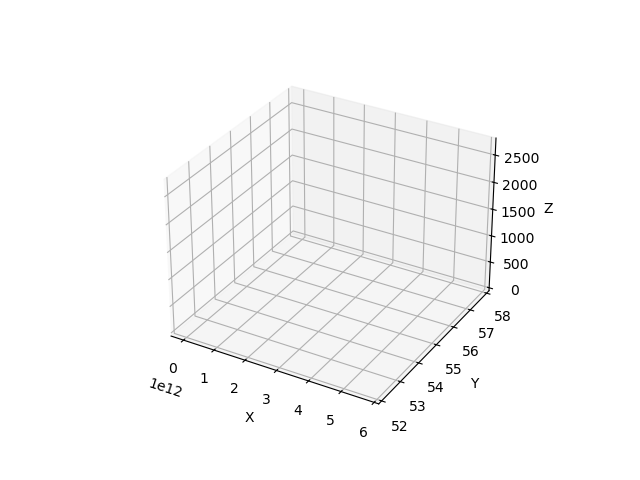

In [ ]:
import sklearn.cluster


def hist3d(data, z, bin_count):
    
    
    ax = fig.add_subplot(111,projection='3d')
    for (data_row, zv) in zip(data, z):
        counts, bins = np.histogram(data_row, bins=bin_count)

        #counts2 = [100] * len(counts)
        # You can provide either a single color or an array. To demonstrate this,
        # the first bar of each set will be colored cyan.
        print("Data = ", data_row)
        #print(bins[:-1])
        print(counts)
        ax.bar(bins[:-1], counts, zs=zv, color='b', zdir='y', alpha=0.8)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

def error_per_distance(data, k, iterations=30):
    #white_data = sp.cluster.vq.whiten(data)
    #centroids,_ = sp.cluster.vq.kmeans(white_data, k, iter=iterations)
    kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(data)
    #clusters = assign_data_to_centroids(white_data, centroids)
    distances = np.array([np.square(np.linalg.norm(data[i] - kmeans.labels_[i])) for i in range(data.shape[0])])
    print("calculated distances for ", k)
    print((-np.sort(-distances))[:20] )
    max_dist = np.max(distances)
    print(distances.shape, max_dist)
    #counts, bins = np.histogram(distances, 300)
    #fig = plt.figure()
    #ax = fig.add_subplot(1, 2, 1)
    #ax.stairs(counts, bins, fill=True)
    #ax2 = fig.add_subplot(1, 2, 2)
    #counts2,bins2 = np.histogram(distances, 100) #np.sort(distances)[:-30]
    #ax2.stairs(counts2, bins2, fill=True)

    #plt.tight_layout()
    #plt.show()
    return distances

#error_per_distance(high_np, 45, iterations=30)
#error_per_distance(high_np, 70)

ks = np.array([55])#np.array([30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
distance_data = np.array([error_per_distance(high_np, k, iterations=10) for k in ks])
hist3d(distance_data, ks, 100)
#z = [1, 4, 6, 9]
#data = []
#for zv in z:
#    nums = [i % 100 * zv for i in np.random.random(40000)] + [500, 600, 1000, 10000] if zv == z[0] else []
#    print("nums = ", nums)
#    data.append(nums) 
#hist3d(data, z, 10)


In [ ]:
min_clusters = 10
max_clusters = 100
X = np.array(range(min_clusters, max_clusters + 1))
Y = np.array([np.sum(error_per_k(high_np, i)) for i in range(min_clusters, max_clusters + 1)])
print("calculated clusters")
plt.plot(X, Y)
print("plotted output")
plt.show()

In [ ]:
min_clusters_2 = 40
max_clusters_2 = 60
X2 = np.array(range(min_clusters_2, max_clusters_2 + 1))
Y2 = np.array([np.sum(error_per_k(high_np, i, 5)) for i in range(min_clusters_2, max_clusters_2 + 1)])
print("calculated clusters")
plt.plot(X2, Y2)
print("plotted output")
plt.show()
